In [1]:
name = "Ciro B Rosa"  # write YOUR NAME

honorPledge = "I affirm that I have not given or received any unauthorized " \
              "help on this assignment, and that this work is my own.\n"


print("\nName: ", name)
print("\nHonor pledge: ", honorPledge)



Name:  Ciro B Rosa

Honor pledge:  I affirm that I have not given or received any unauthorized help on this assignment, and that this work is my own.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

%matplotlib inline

In [3]:
(X_train_ori, y_train_ori), (X_test_ori, y_test_ori) = mnist.load_data()

print(X_train_ori.shape, y_train_ori.shape)
print(X_test_ori.shape, y_test_ori.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


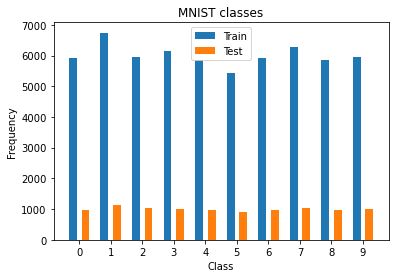

In [4]:
labels = ["%s"%i for i in range(10)]

unique, counts = np.unique(y_train_ori, return_counts=True)
uniquet, countst = np.unique(y_test_ori, return_counts=True)

fig, ax = plt.subplots()
rects1 = ax.bar(unique - 0.2, counts, 0.25, label='Train')
rects2 = ax.bar(unique + 0.2, countst, 0.25, label='Test')
ax.legend()
ax.set_xticks(unique)
ax.set_xticklabels(labels)

plt.title('MNIST classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

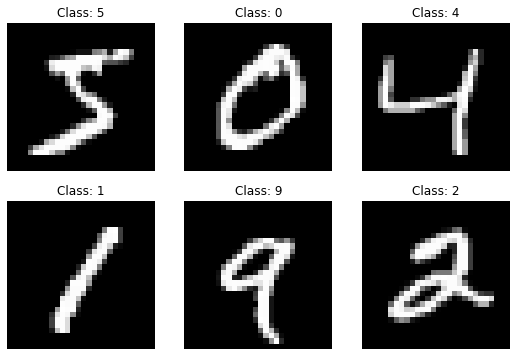

In [5]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train_ori[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

In [6]:
# Reduce the image size to its half 
X_train = np.array([image[::2, 1::2] for image in X_train_ori])
X_test  = np.array([image[::2, 1::2] for image in X_test_ori])

y_train = y_train_ori
y_test = y_test_ori

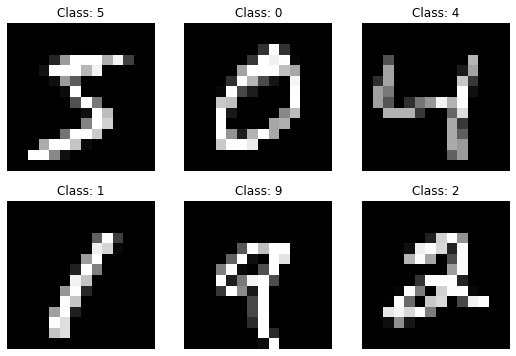

In [7]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

In [8]:
X_train = (X_train/255.0).astype('float32').reshape((60000,14*14))
X_test = (X_test/255.0).astype('float32').reshape((10000,14*14))

print(X_train.dtype)
print(X_test.dtype)

print("\nShape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

print("\nMinimum value in X_train:", np.amin(X_train))
print("Maximum value in X_train:", np.amax(X_train))

print("\nMinimum value in X_test:", np.amin(X_test))
print("Maximum value in X_test:", np.amax(X_test))


float32
float32

Shape of X_train:  (60000, 196)
Shape of X_test:  (10000, 196)

Minimum value in X_train: 0.0
Maximum value in X_train: 1.0

Minimum value in X_test: 0.0
Maximum value in X_test: 1.0
